In [4]:
import cv2
from pathlib2 import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

#### Импорт данных

In [5]:
def read_data(mask):
    file_names = glob(str(mask))
    file_names.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    im_path_es = []
    for file_name in file_names:
        file_path = Path(file_name)
        im_path = file_name
        im_path_es.append(im_path)
    df_all = pd.DataFrame({
        'file_path': im_path_es})
    return df_all

In [6]:
df_all = read_data(mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes') / '**'/ '**' / '**'/ '***.png')

In [8]:
mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes') / '**'/ '**' / '**'/ '***.png'

In [9]:
def events1800(df_all,  v_record):
    v_record = df_all[df_all.file_path.str.contains(f'{v_record}')]
    v_record_events = v_record[v_record.file_path.str.contains('event')]
    file_pathes = v_record_events['file_path'].values
    return file_pathes

In [10]:
file_pathes = events1800(df_all, v_record = 'tser2')

6.6. двумерная гистограмма: для каждого пикселя количество моментов времени, когда он начинал гореть (то есть смена значения пикселя с 0 на 1).

In [11]:
def count_hist(file_pathes):
    array = file_pathes[0].split('\\')
    title = array[5]
    I = cv2.imread(str(file_pathes[0]))
    img1 = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    Mo = np.zeros(img1.shape)
    for i in range(len(file_pathes) - 1):
        I = cv2.imread(str(file_pathes[i]))
        img1 = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        img1[img1 >= 1] = 1
        M = cv2.imread(str(file_pathes[i+1]))
        img2 = cv2.cvtColor(M, cv2.COLOR_BGR2GRAY)
        img2[img2 >= 1] = 1
        M = img2 - img1
        M[M ==  255] = 0
        Mo = Mo + M
    return Mo, title

In [15]:
def D2_histogfamm(Mo, title):
    h, w = Mo.shape[0], Mo.shape[1]
    hist = plt.figure(figsize=(6.5,3.37))
    plt.title(f'{title}', fontsize = 10)
    plt.gca().invert_yaxis()
    plt.plot([w - 71, w - 20], [h - 20, h - 20], color='w', linewidth=1)
    plt.text(w - 75, h-25, '10 $\mu$m', color = 'w', style='italic', size='small')
    plt.imshow(Mo, cmap='gray')
    cbar = plt.colorbar(label= "Количество смен значения пикселя", orientation="vertical",shrink=.75)
    return hist

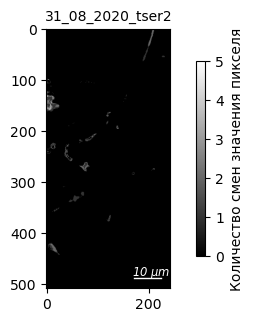

In [21]:
hist = D2_histogfamm(Mo = count_hist(file_pathes)[0], title = count_hist(file_pathes)[1])

#### Визуализация зависимости площади самой большой области в зависимости от номера кадра.


In [24]:
def count_Sq_max(file_pathes):
    maximum_S = []
    for i in range(len(file_pathes)):
        I = cv2.imread(str(file_pathes[i]))
        img1 = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        ret,thresh_img = cv2.threshold(img1, 200, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        areas = []
        for j in range(len(contours)):
            area = cv2.contourArea(contours[j])
            size = area * (1/5.1) ** 2 # 5.1 pixel = 1 mkm
            areas.append(round(size, 3))
        max_area = max(areas)
        maximum_S.append(max_area)    
    return maximum_S

In [25]:
def plot(maximum_S, title):
    t = np.arange(0, len(maximum_S))/2
    plt.rcParams['font.family'] = 'serif'
    PLOT = plt.figure(figsize = (6.5, 3.37), dpi = 300.0)
    plt.rc('axes', titlesize =  8) 
    plt.title("Зависимость площади самой большой области от номера кадра ")
    plt.plot(t, maximum_S, '#FF0055', linewidth = 2, label = f'{title}')
    plt.ylabel('Площадь (S), $\mu$m$^2$')
    plt.legend()
    plt.xlabel('Время t, мин')
    plt.grid(which = 'major')
    plt.grid(which = 'minor')
    plt.minorticks_on()
    df = []
    for i in range(len(t)):
        if t[i] % 60 == 0:
            df.append(int(t[i]//60))
    plt.xticks (ticks=np.arange(min(t), max(t), 60.0), labels=df) 
    plt.show()
    return PLOT

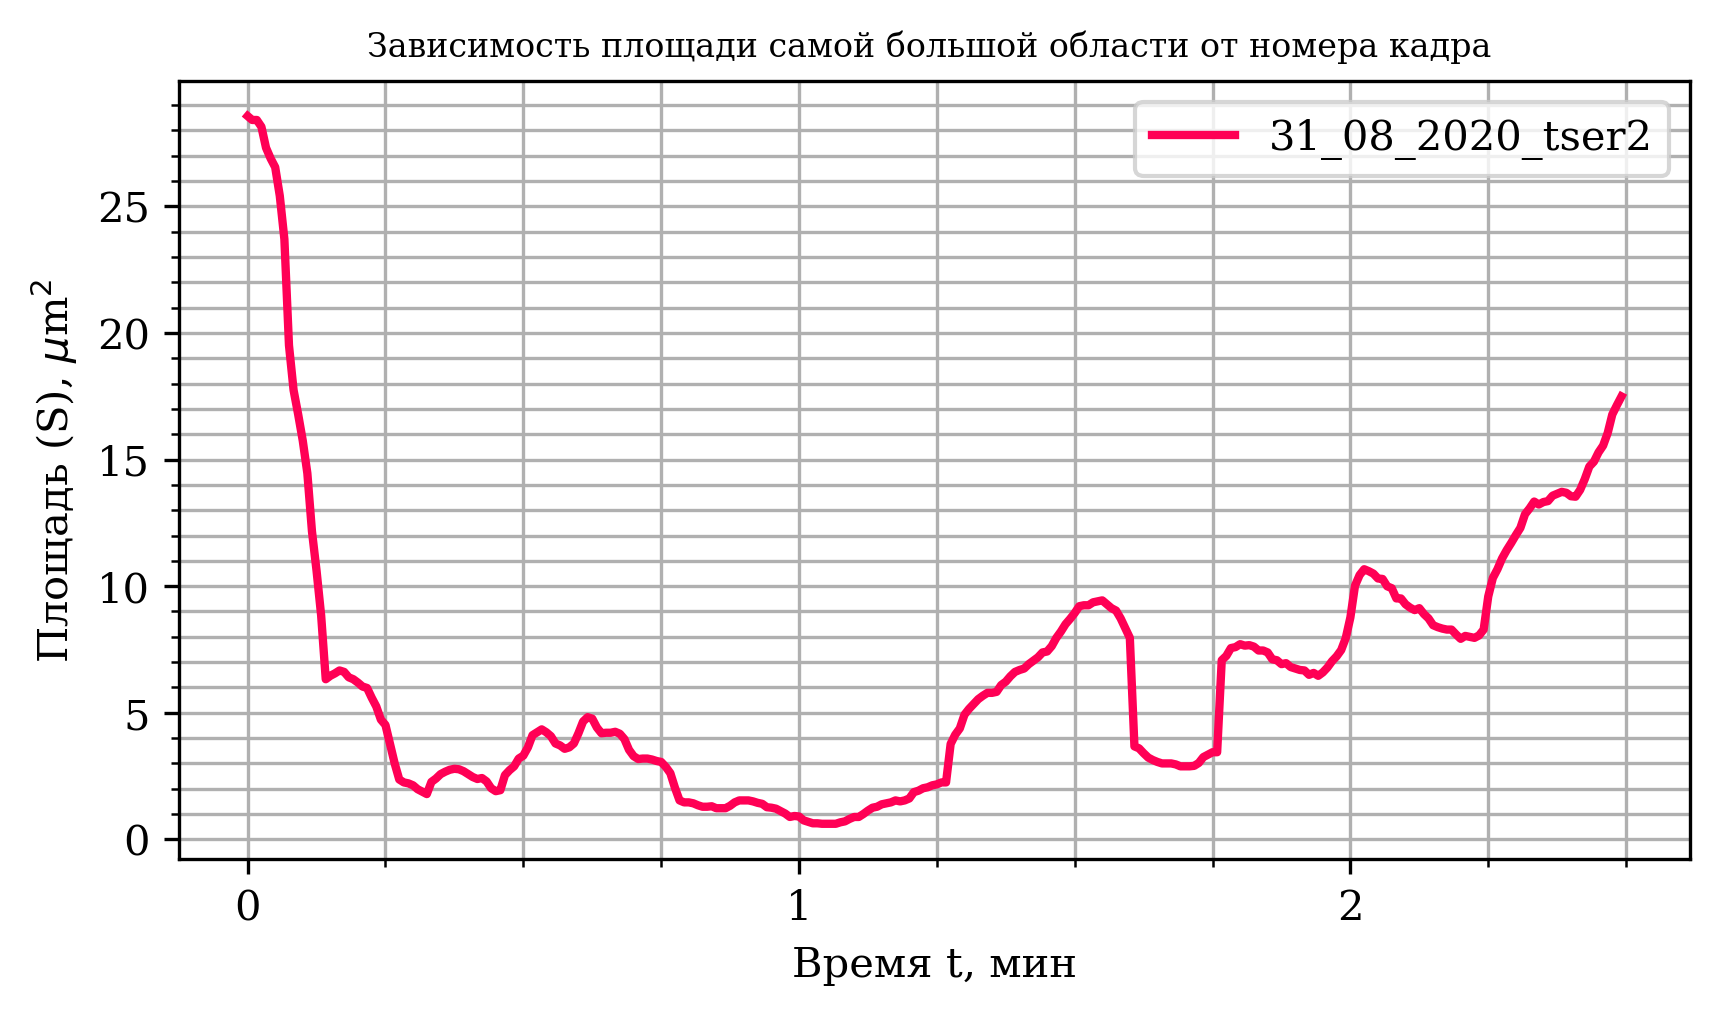

In [26]:
PLOT = plot(maximum_S=count_Sq_max(file_pathes), title = count_hist(file_pathes)[1])

#### Сохранение данных (из 6.9)

In [36]:
def save_table(maximum_S, file_pathes, data_dir):
    data_path = Path(data_dir)
    array = file_pathes[0].split('\\')
    title = array[5]
    table_for_part = pd.DataFrame({
        'Square_max, кв. мкм': maximum_S, 'file_path': file_pathes})
    table_for_part.to_excel(data_path /f'{title}.xlsx', index= False)

In [43]:
save_table(data_dir= r'C:/Users/sibir/Desktop/results', file_pathes = file_pathes, maximum_S=count_Sq_max(file_pathes))

#### Сохранение гистограмм и графиков в png - формате

In [18]:
def save_hist(hist, file_pathes, data_dir):
    data_path = Path(data_dir)
    array = file_pathes[0].split('\\')
    title = array[5]
    file_location_png = data_path/f'{title}_hist.png'
    hist.savefig(file_location_png, dpi=300, bbox_inches='tight')

In [29]:
def save_plt(PLOT, file_pathes, data_dir):
    data_path = Path(data_dir)
    array = file_pathes[0].split('\\')
    title = array[5]
    file_location_png = data_path / f'{title}_plot.png'
    PLOT.savefig(file_location_png, dpi=300, bbox_inches='tight')

In [37]:
save_table(maximum_S = [0], file_pathes =  ['a\\b\\c\\d\\e\\r'], data_dir = r'C:/Users/sibir/Desktop/results')

In [34]:
save_plt(PLOT, file_pathes = ['a\\b\\c\\d\\e\\r'], data_dir = r'C:/Users/sibir/Desktop/results')


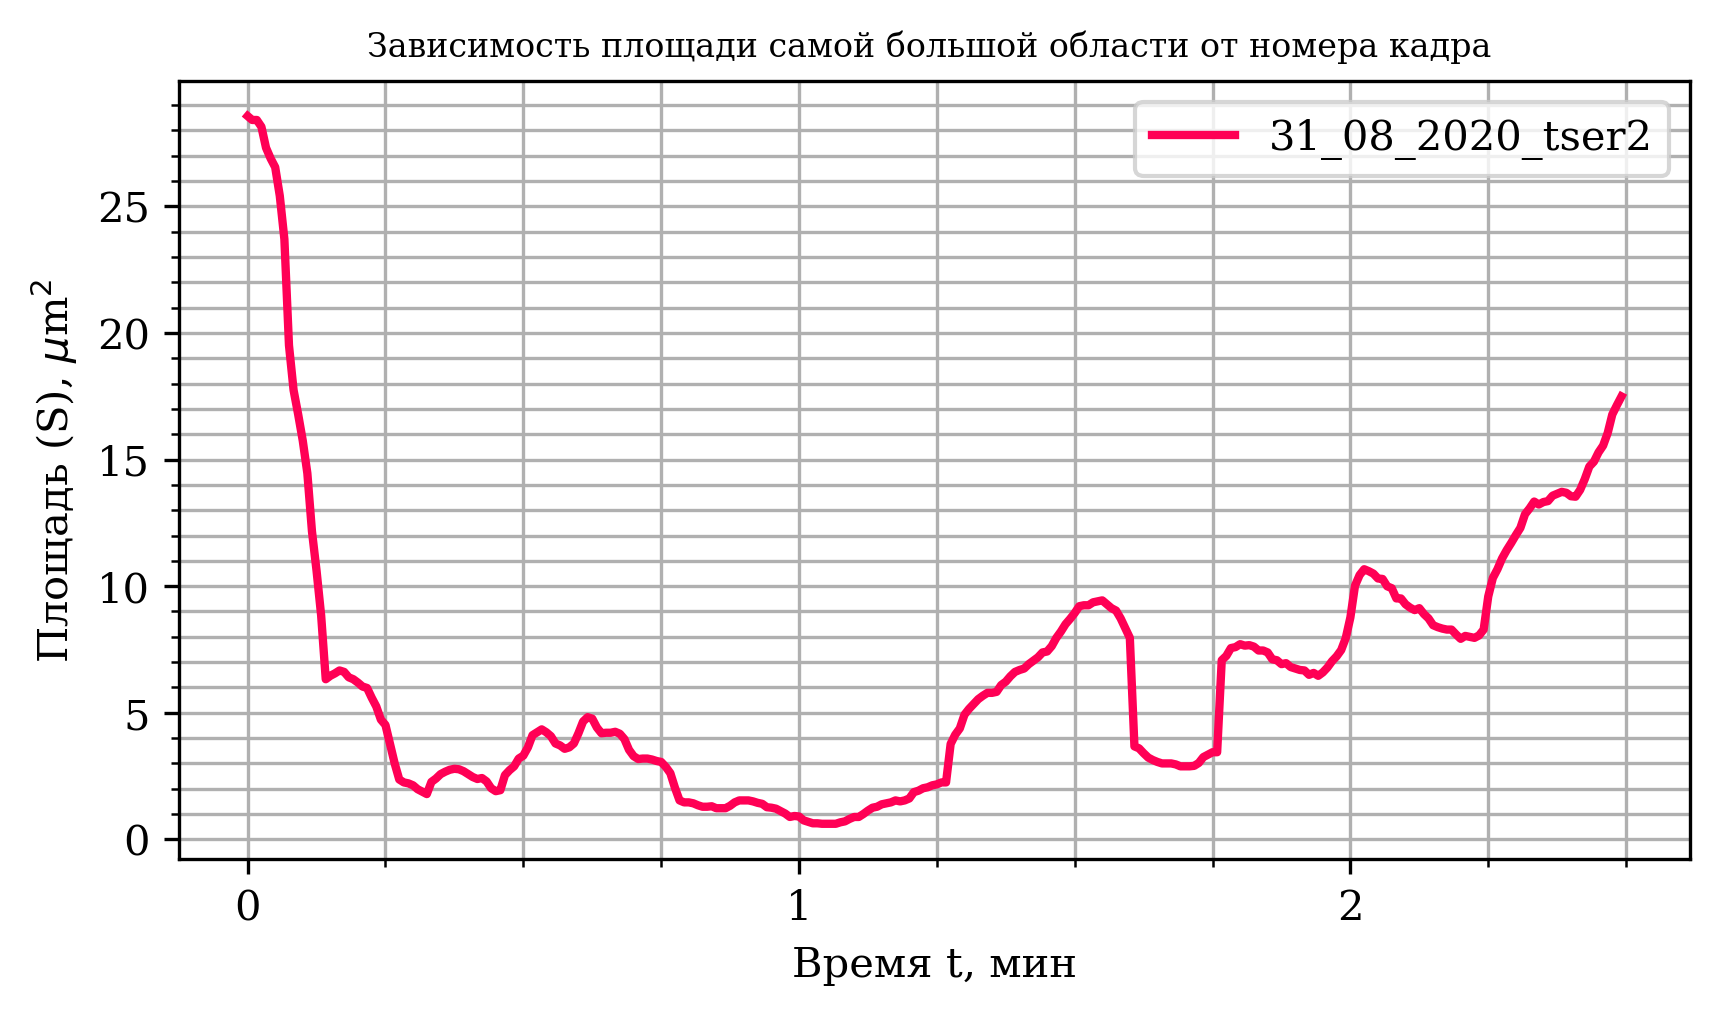

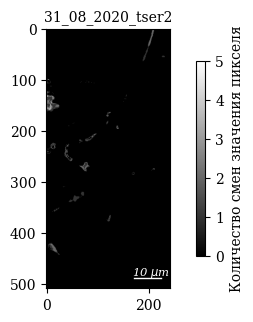

In [46]:
def func8(file_pathes, data_dir):
    maximum_S = count_Sq_max(file_pathes)
    title=count_hist(file_pathes)[1]
    save_table(maximum_S, file_pathes, data_dir)
    PLOT = plot(maximum_S, title = count_hist(file_pathes)[1])
    Mo = count_hist(file_pathes)[0]
    hist = D2_histogfamm(Mo, title)
    save_hist(hist, file_pathes, data_dir)
    save_plt(PLOT, file_pathes, data_dir)
func8(file_pathes, data_dir = r'C:/Users/sibir/Desktop/results')

In [48]:
def type_videorecords(df_ev):
    df1 = df_ev[df_ev.file_path.str.contains('tser1')]
    df2 = df_ev[df_ev.file_path.str.contains('tser2')]
    df3 = df_ev[df_ev.file_path.str.contains('tser3')]
    df4 = df_ev[df_ev.file_path.str.contains('tser4')]
    df5 = df_ev[df_ev.file_path.str.contains('2016-05-18')] 
    df6 = df_ev[df_ev.file_path.str.contains('2016-05-26')]
    return df1, df2, df3, df4, df5, df6

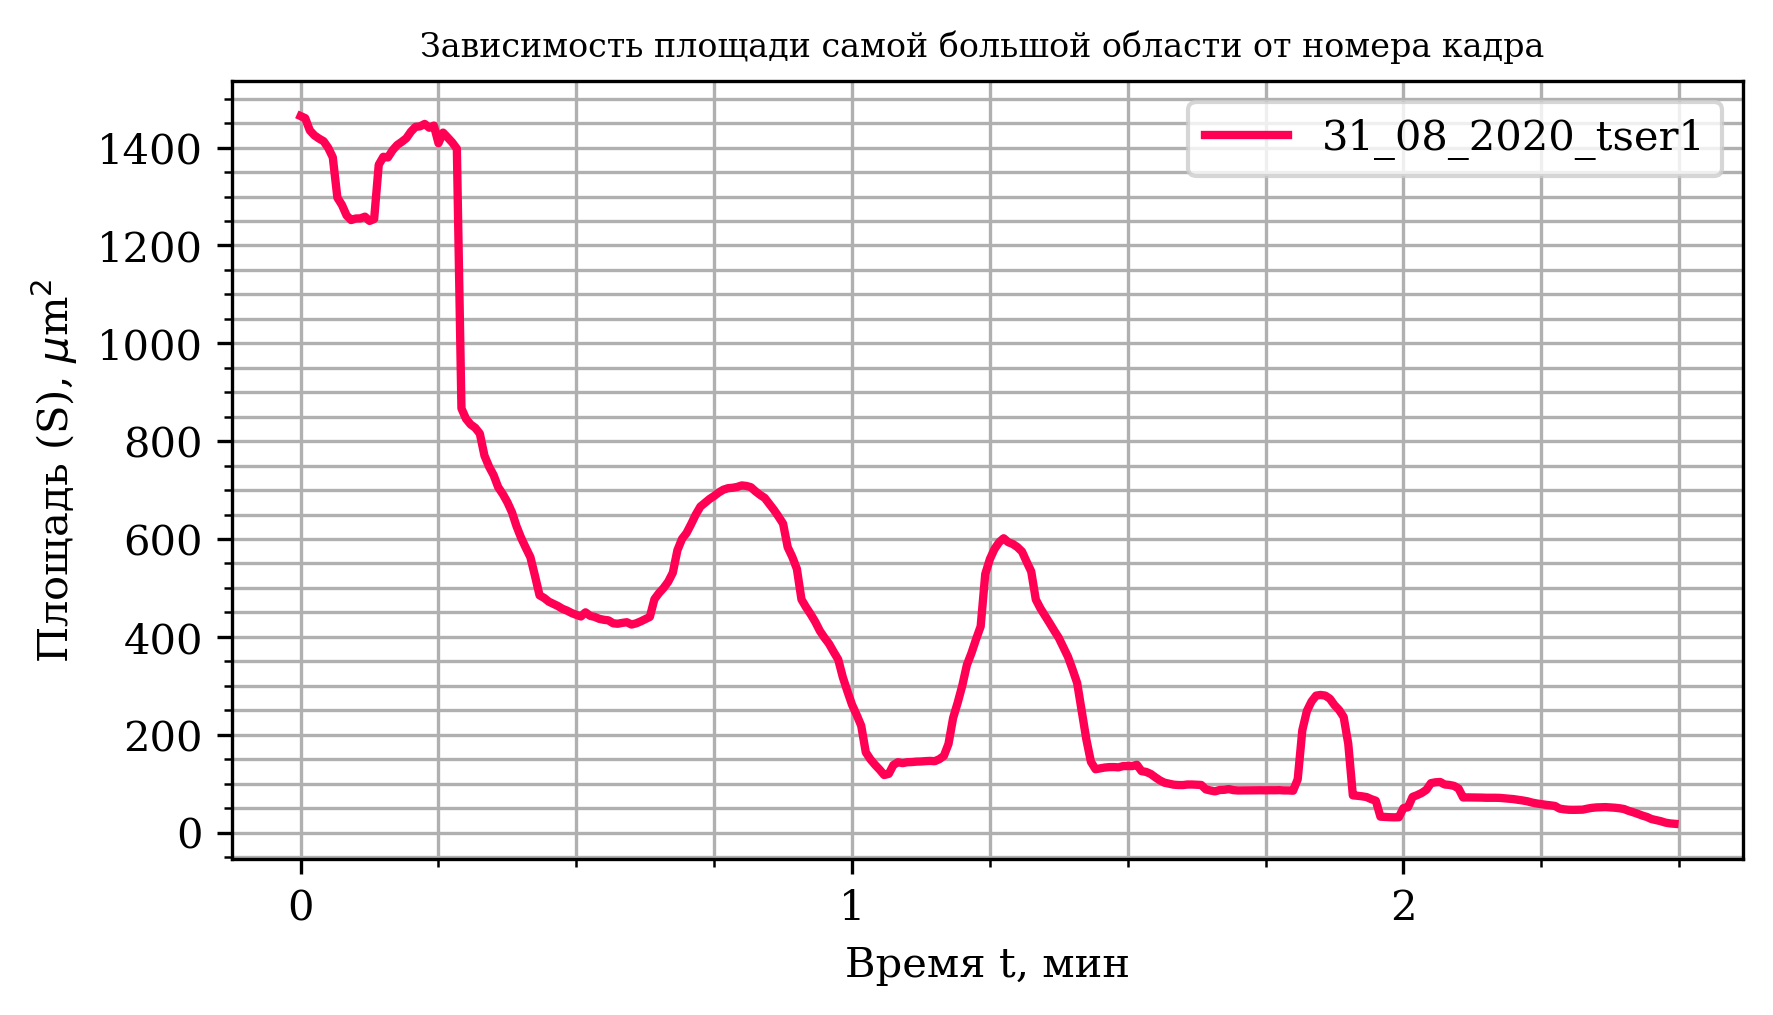

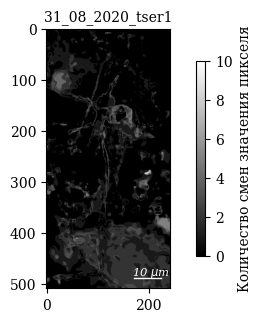

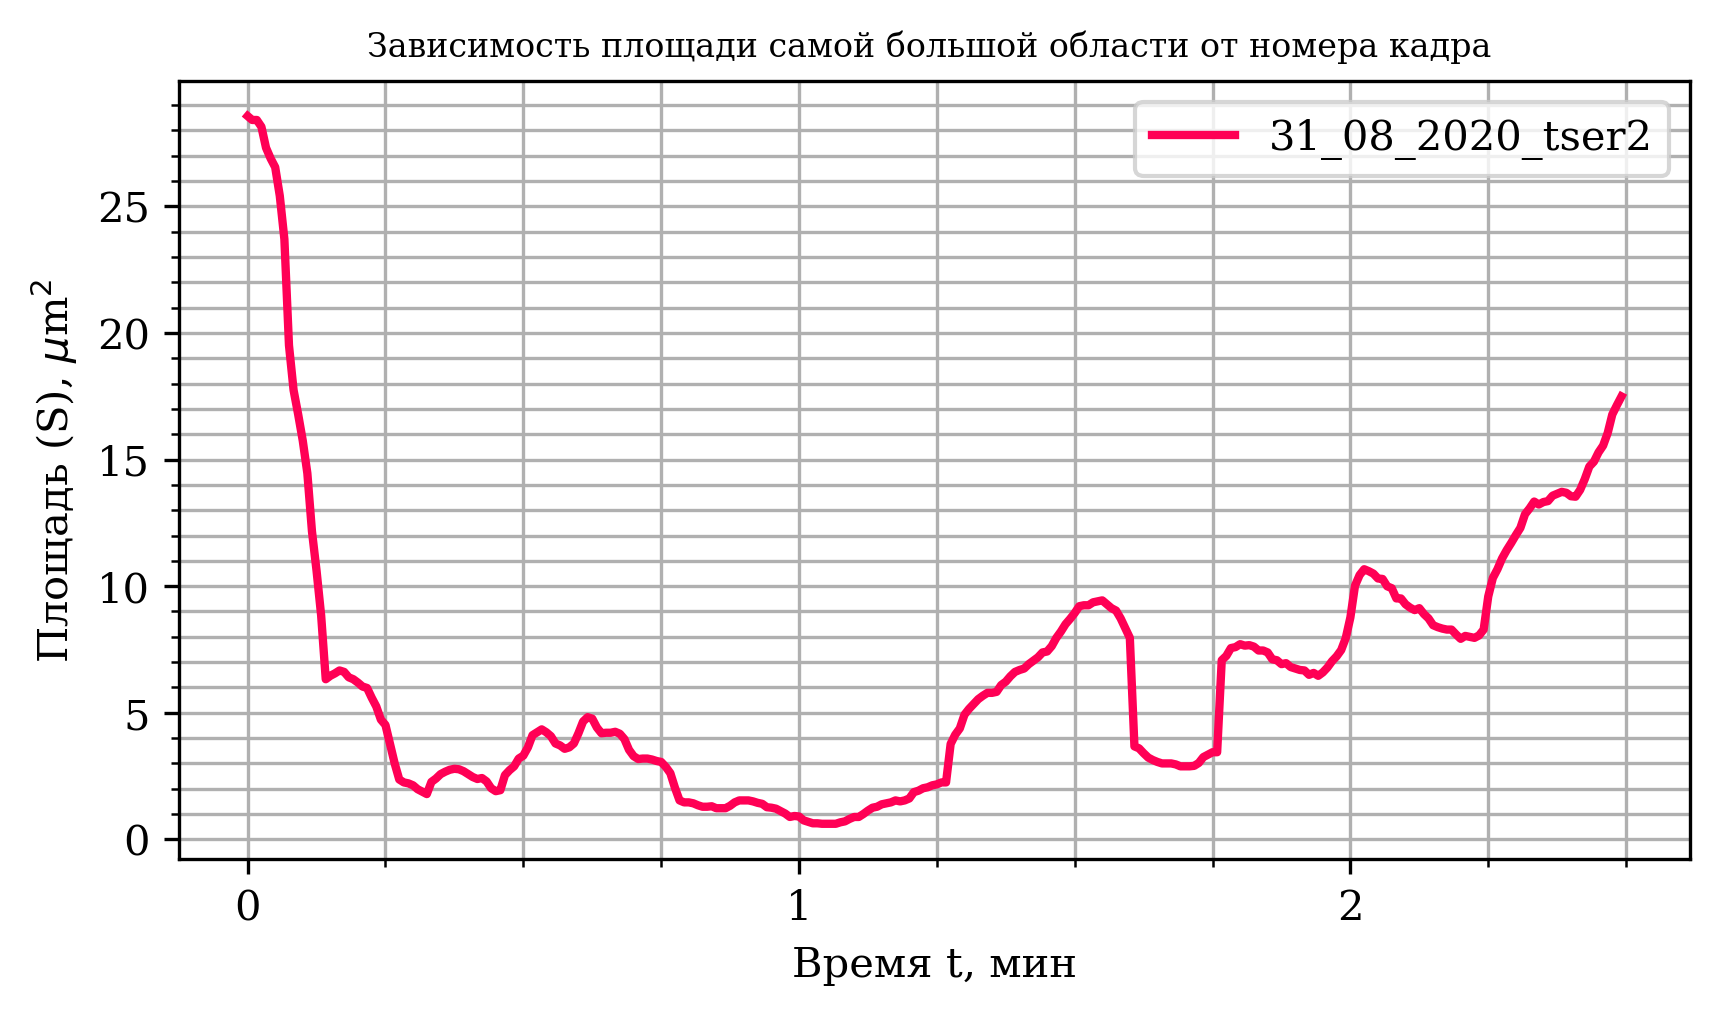

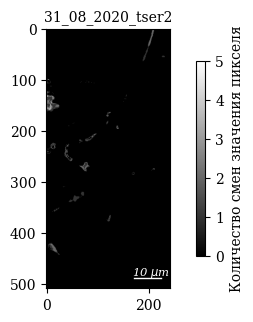

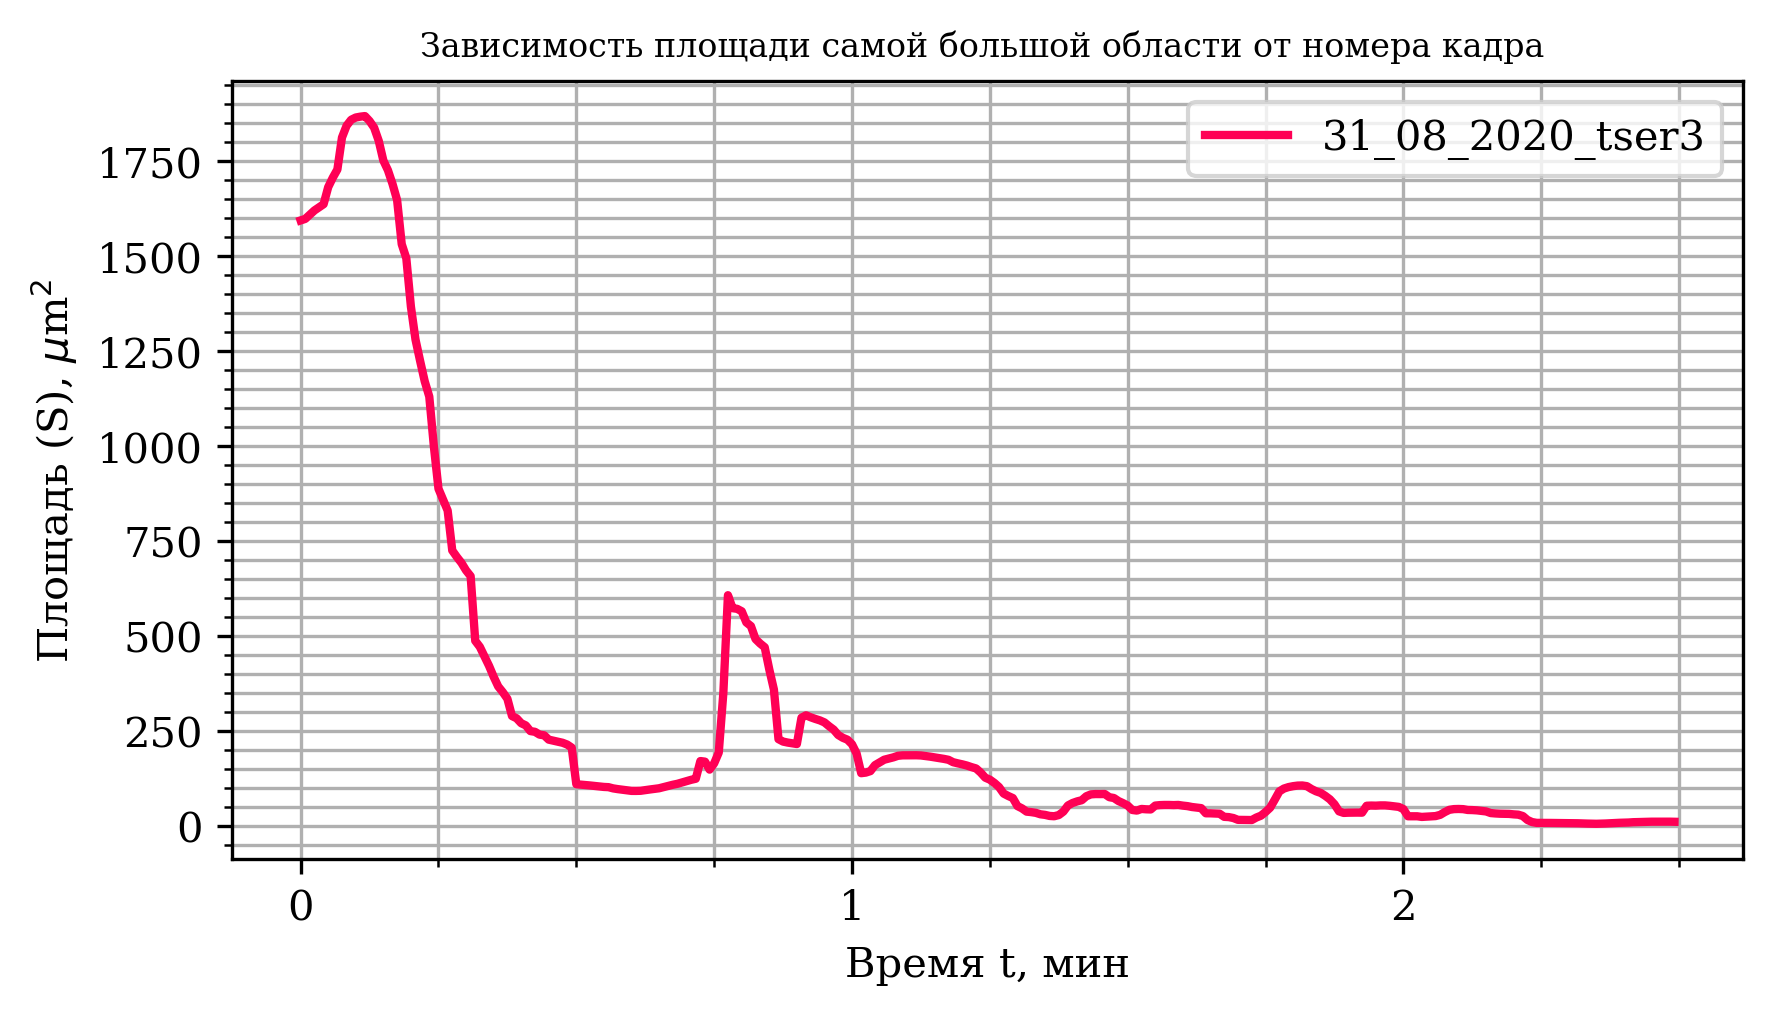

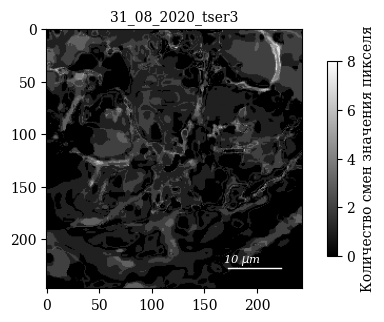

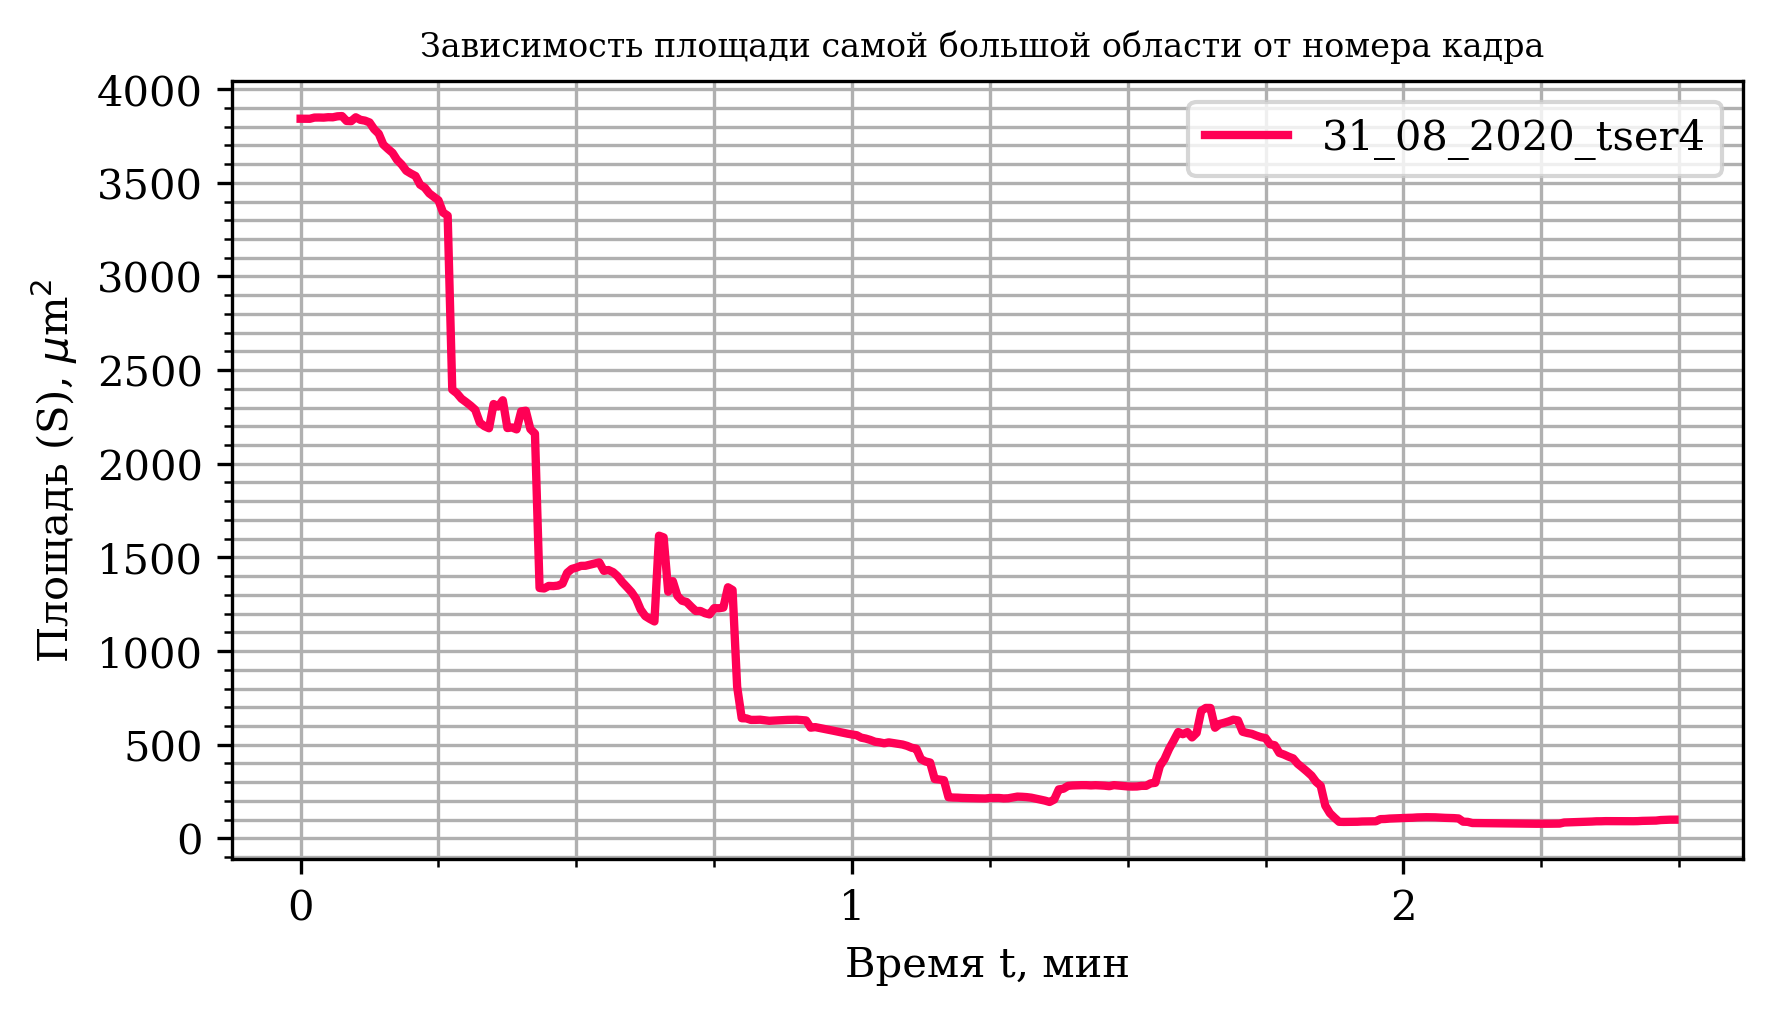

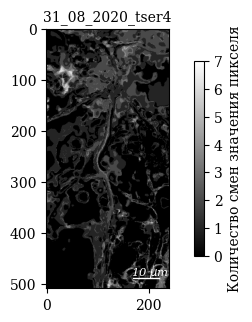

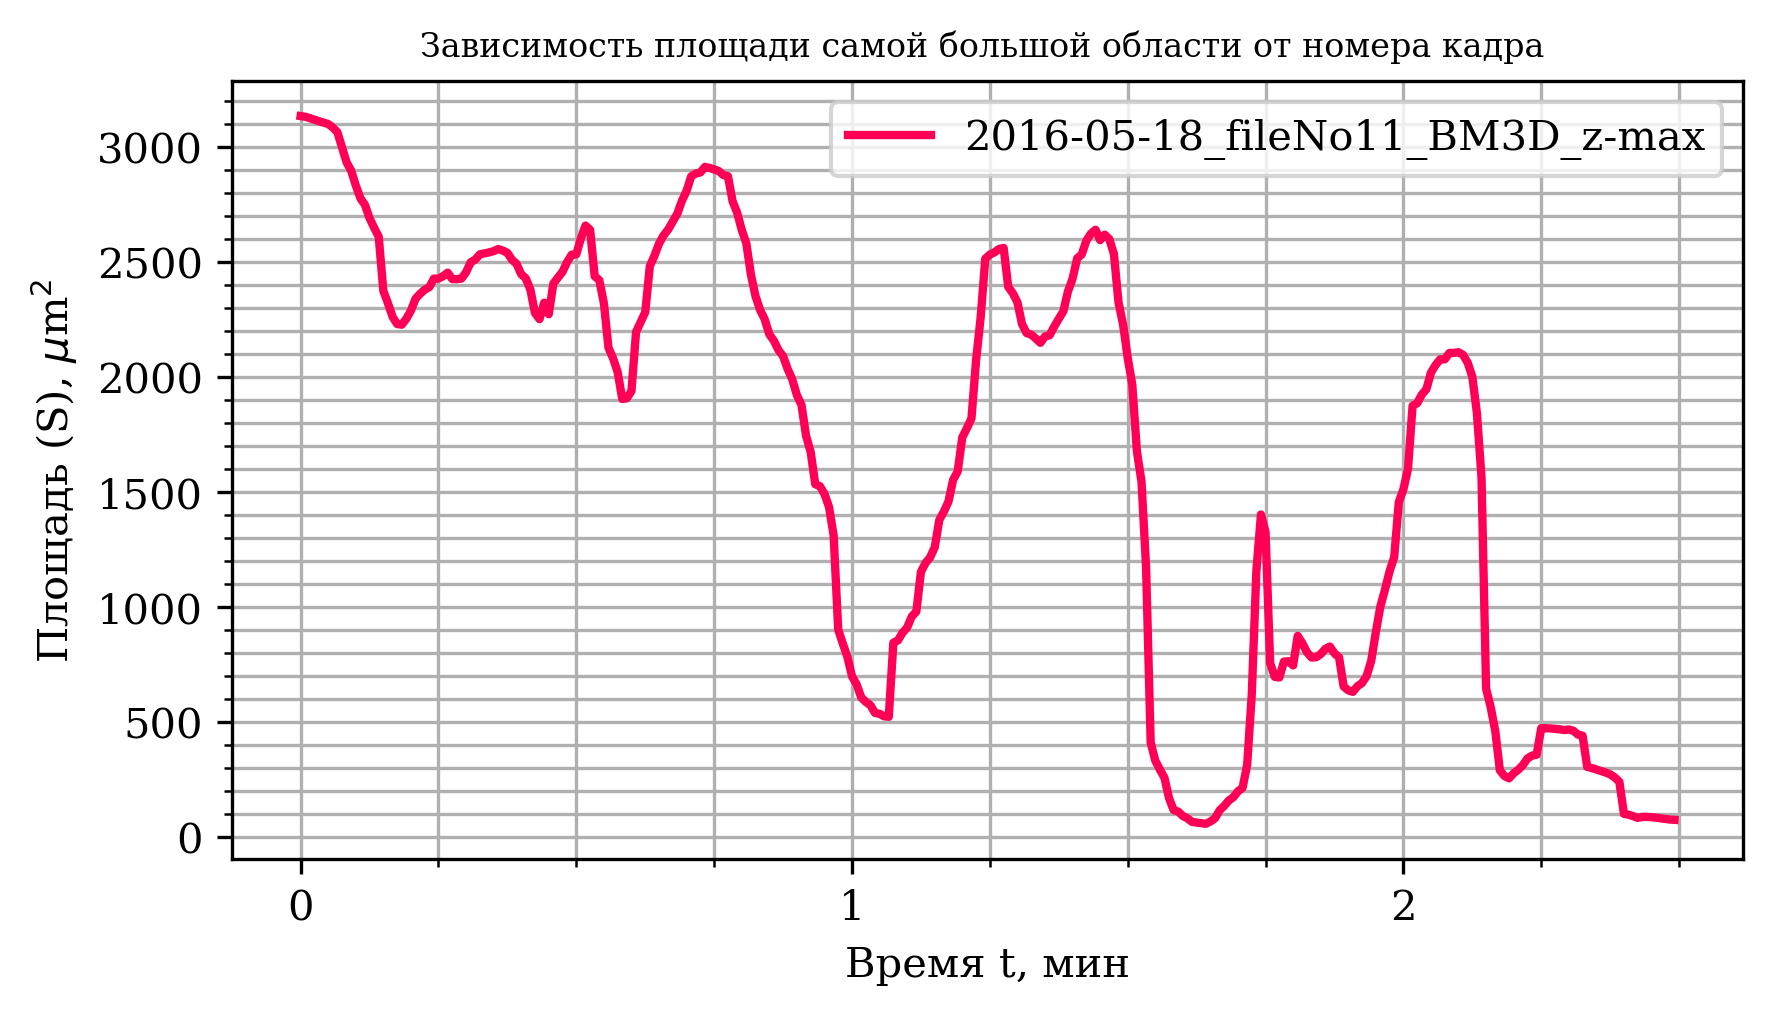

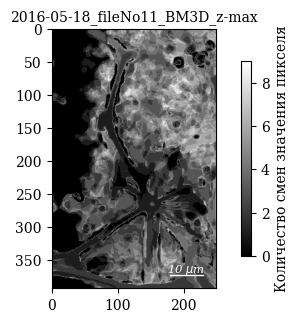

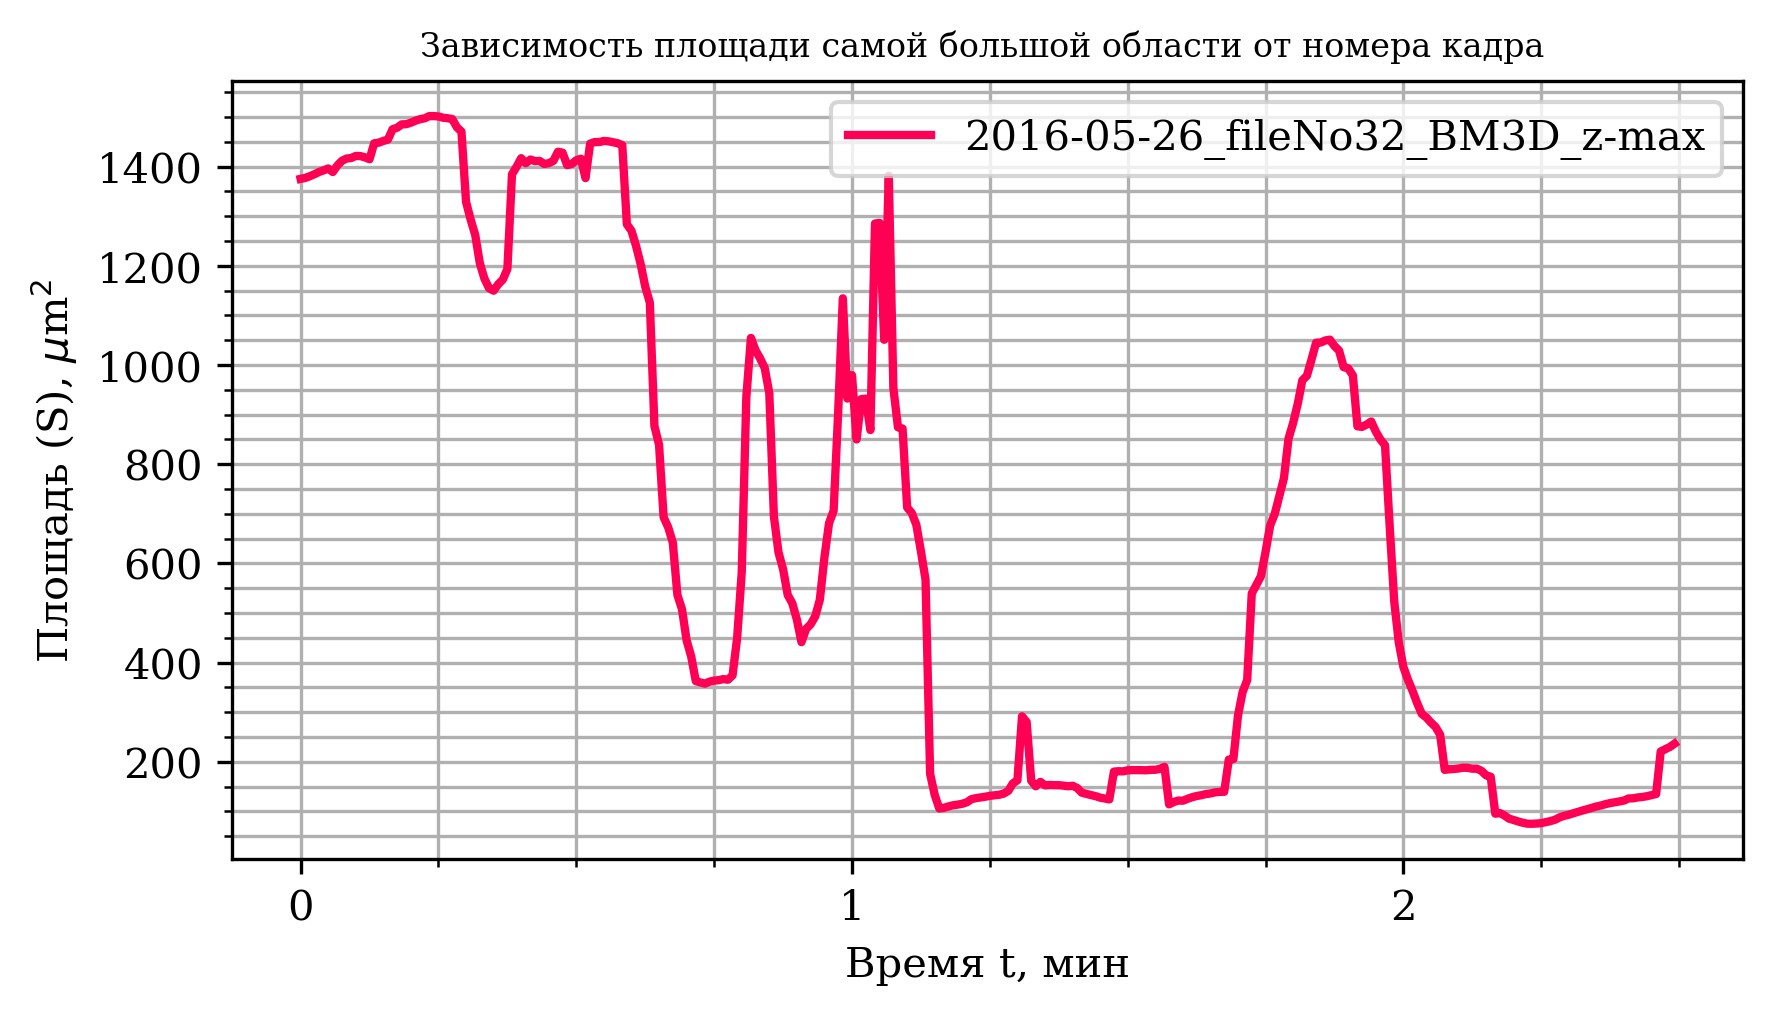

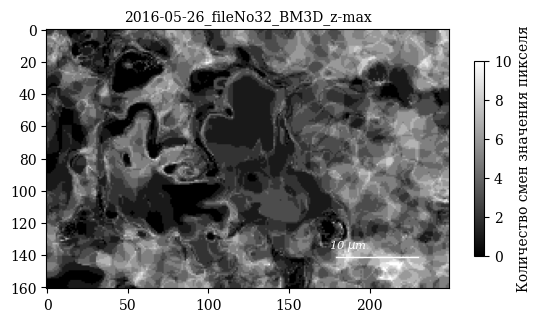

In [50]:
def function_to_func8(df_ev, data_dir):
    result = type_videorecords(df_ev)
    for i in range(len(result)):
        file_pathes = result[i]['file_path'].values
        func8(file_pathes, data_dir)
function_to_func8(df_ev = df_all[df_all.file_path.str.contains('event')], data_dir = r'C:/Users/sibir/Desktop/results')  

In [2]:
import astro_pack

In [3]:
from astro_pack import all_IMAGES, xy_dataFrame, countforhist, D2_hist

In [4]:
df_all = all_IMAGES.read_data(mask = Path(r'C:/nn/Task_Astrocytes/Task_Astrocytes') / '**'/ '**' / '**'/ '***.png')

In [5]:
file_pathes = xy_dataFrame.events1800(df_all, v_record = 'tser1')

In [6]:
Mo = countforhist.count_hist(file_pathes)[0]
title = countforhist.count_hist(file_pathes)[1]

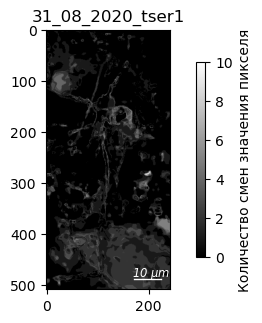

In [7]:
hist = D2_hist.D2_histogfamm(Mo, title)

In [6]:
from astro_pack import square_number_of_shot
from astro_pack import plot_of_means_of_S, save_histogramm, save_plot, tablesave, file_for_func8, file_for_func_to_func8, file_with_6dfs

In [18]:
maximum_S = square_number_of_shot.count_Sq_max(file_pathes)

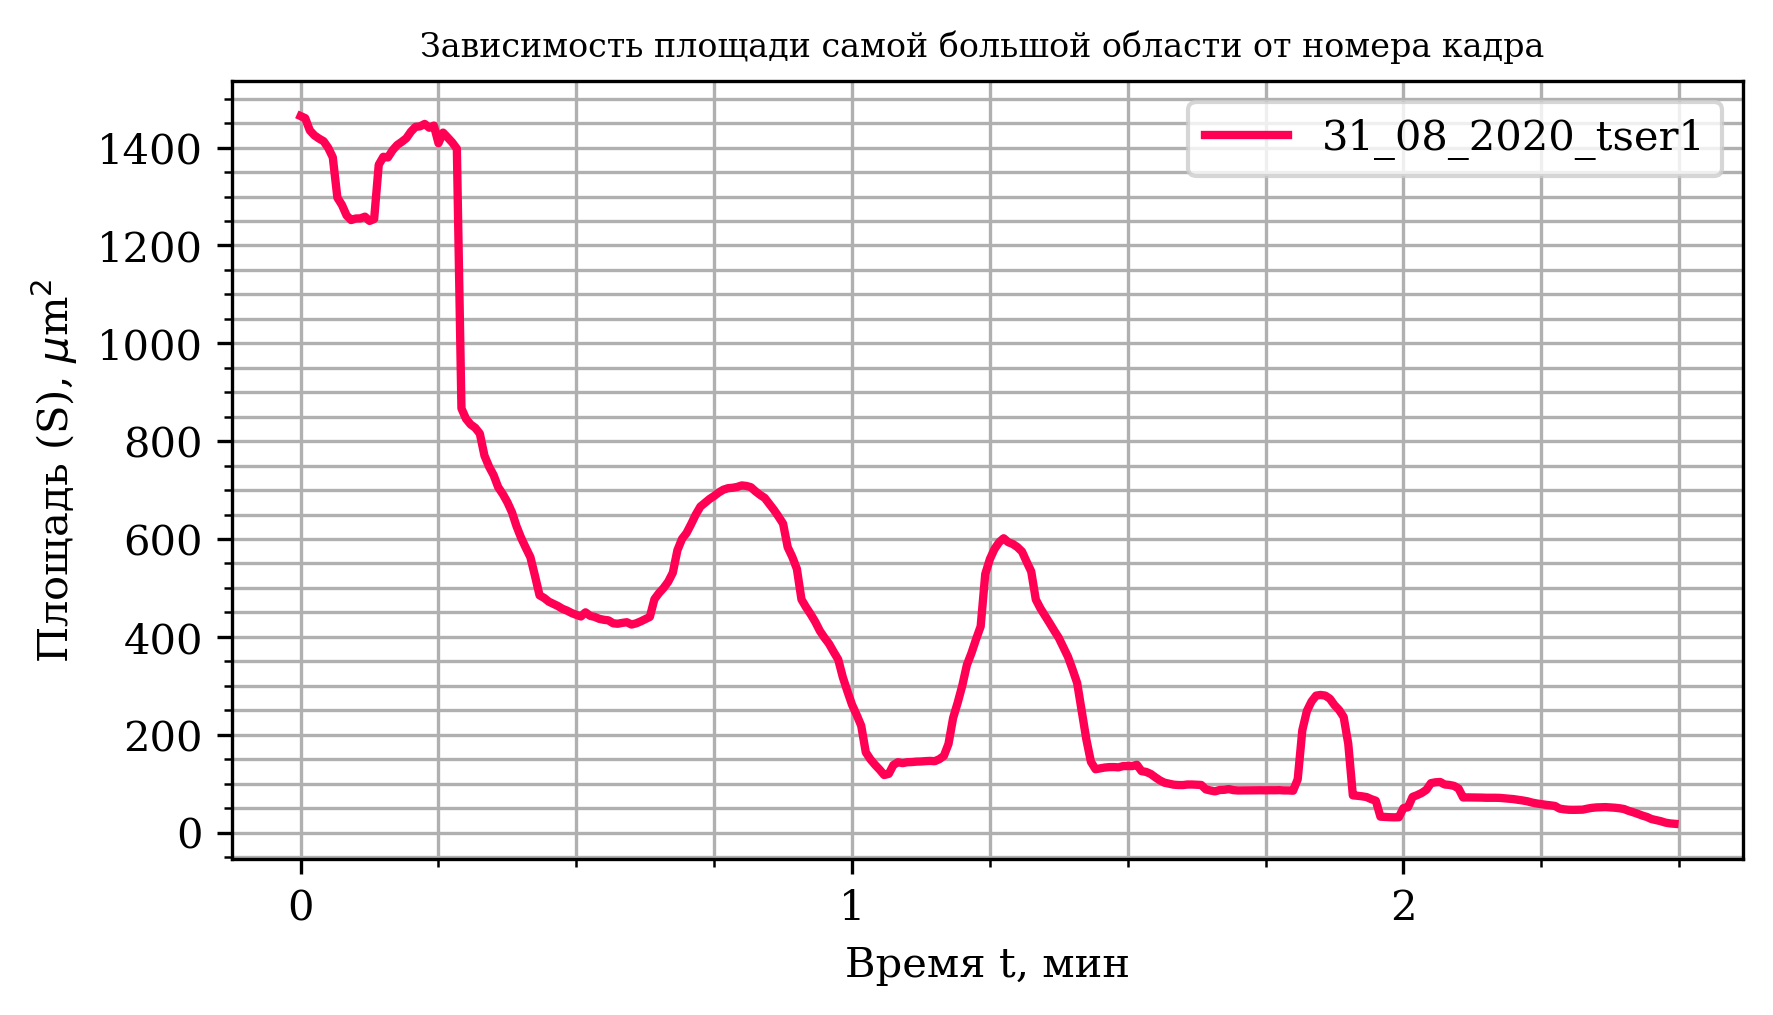

In [10]:
PLOT = plot_of_means_of_S.plot(maximum_S, title)

In [21]:
save_plot.save_plt(PLOT, file_pathes, data_dir = r'C:/Users/sibir/Desktop/results')

In [12]:
save_histogramm.save_hist(hist, file_pathes, data_dir = r'C:/Users/sibir/Desktop/results')

In [22]:
tablesave.save_table(maximum_S, file_pathes, data_dir = r'C:/Users/sibir/Desktop/results')

In [14]:
file_with_6dfs.type_videorecords(df_ev=df_all[df_all.file_path.str.contains('event')])

(                                              file_path
 0     C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 2     C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 4     C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 6     C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 8     C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 ...                                                 ...
 1184  C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 1186  C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 1188  C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 1190  C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 1192  C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 
 [300 rows x 1 columns],
                                               file_path
 18    C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 20    C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 22    C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 24    C:\nn\Task_Astrocytes\Task_Astrocytes\31_08_20...
 26 

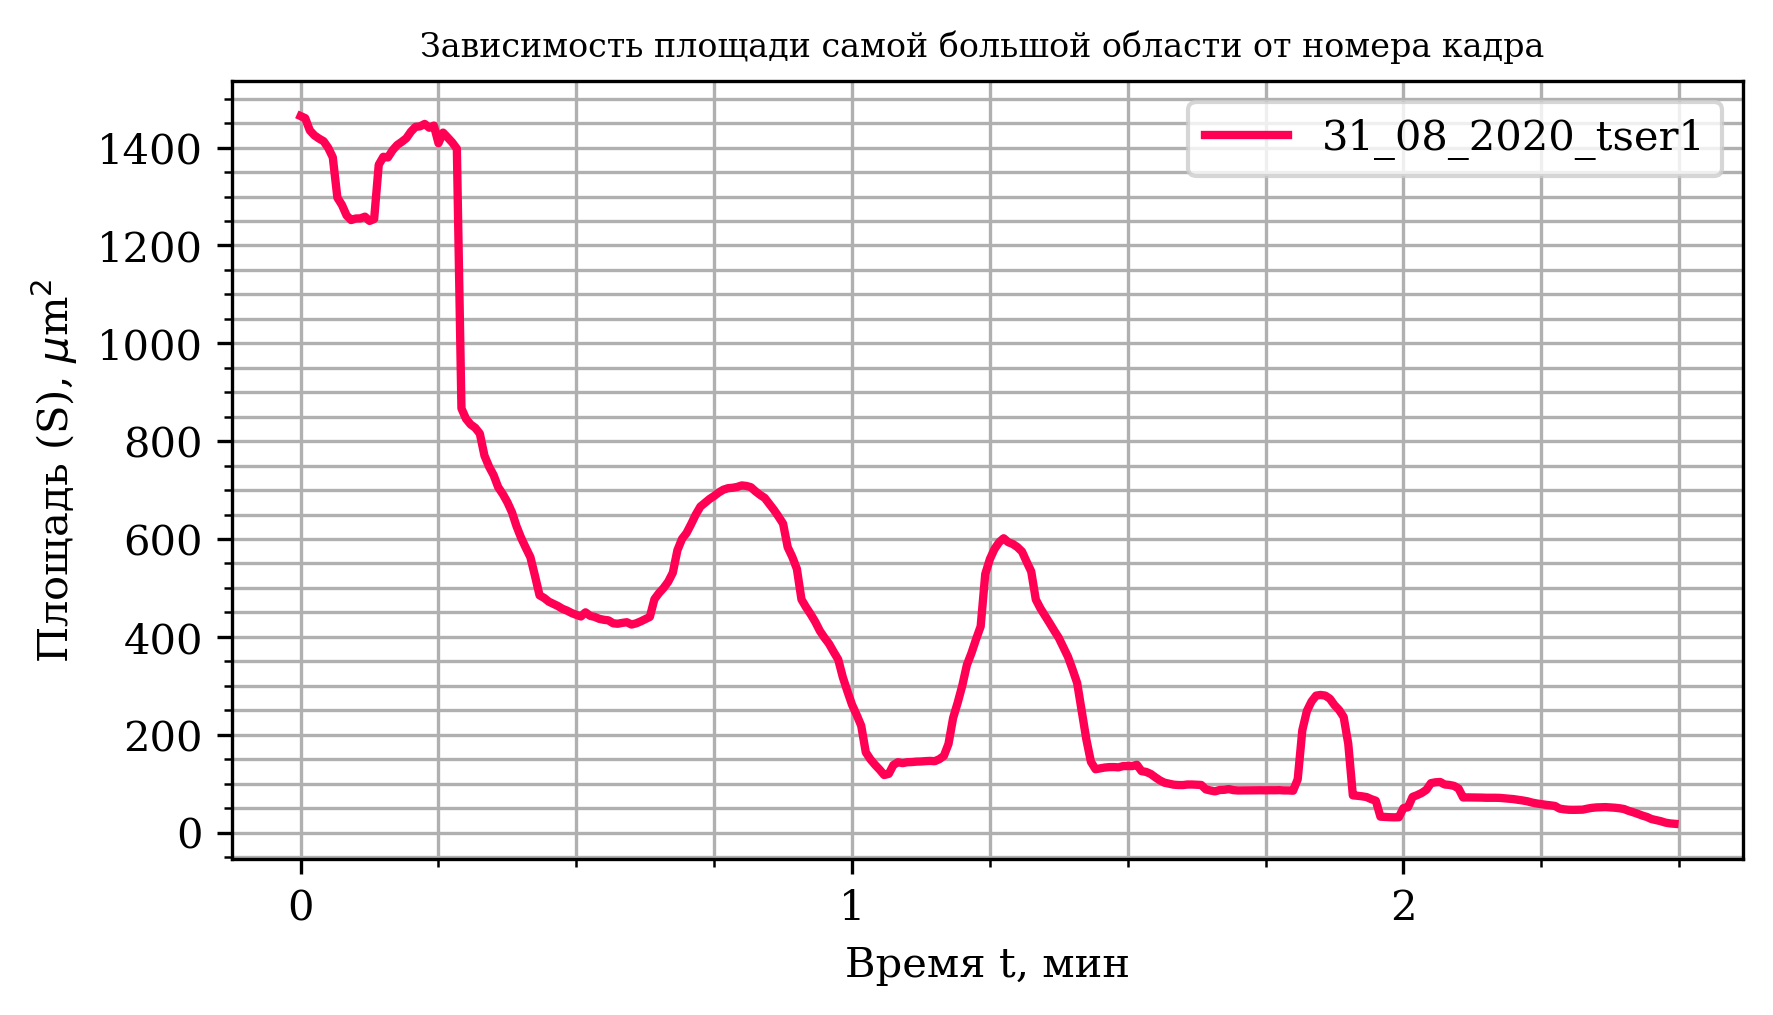

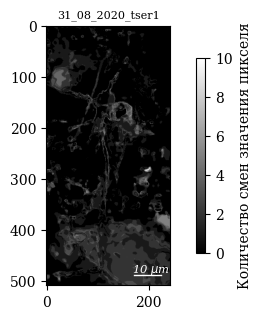

In [7]:
file_for_func8.func8(file_pathes, data_dir = r'C:/Users/sibir/Desktop/results')

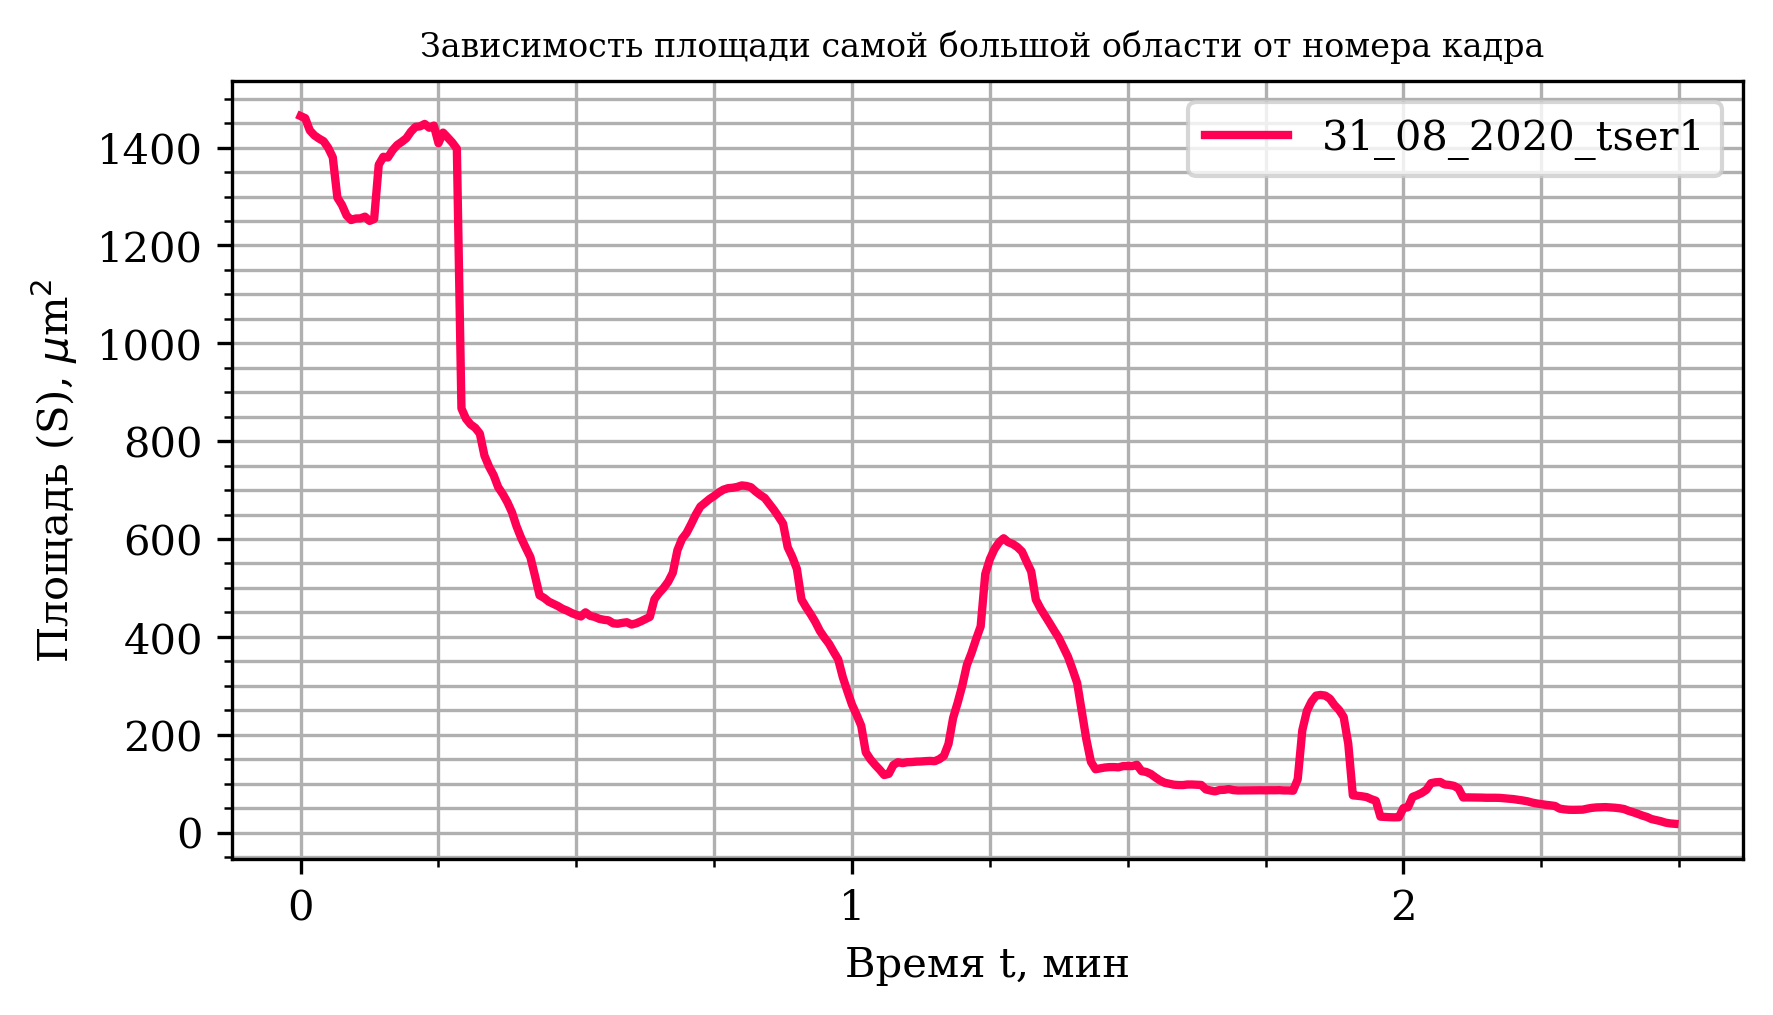

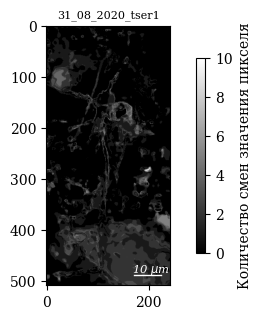

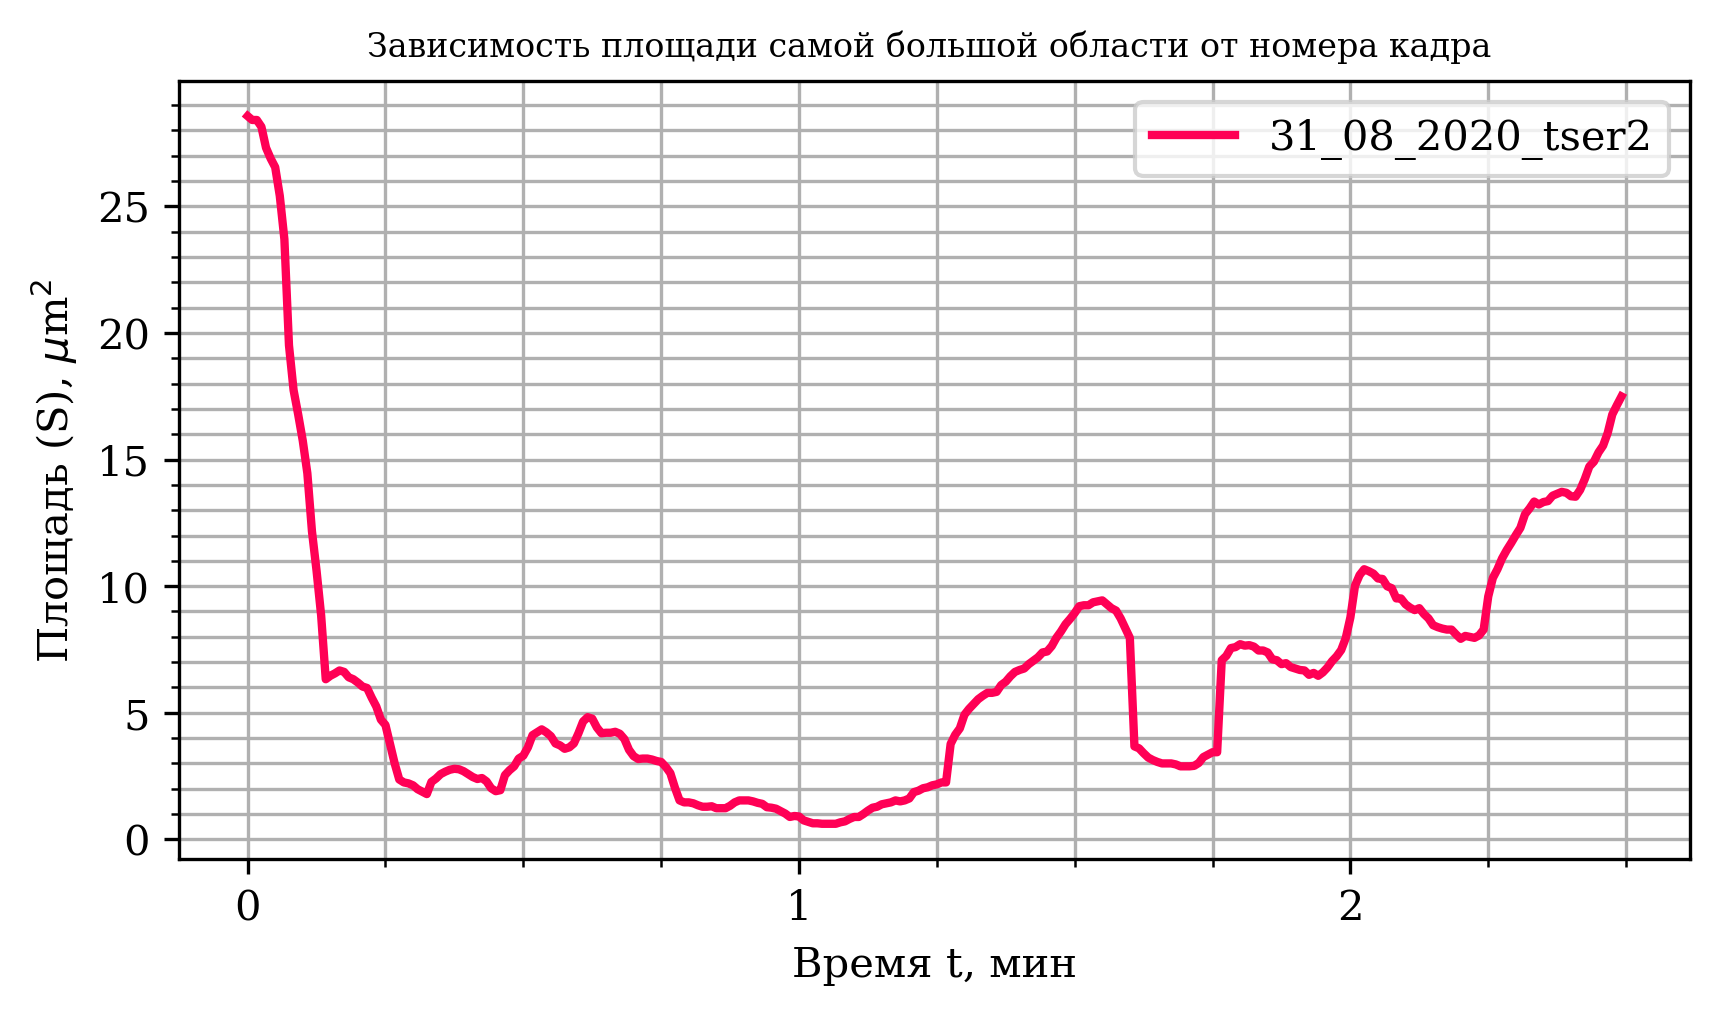

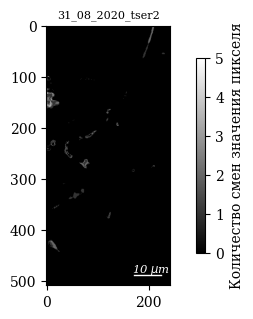

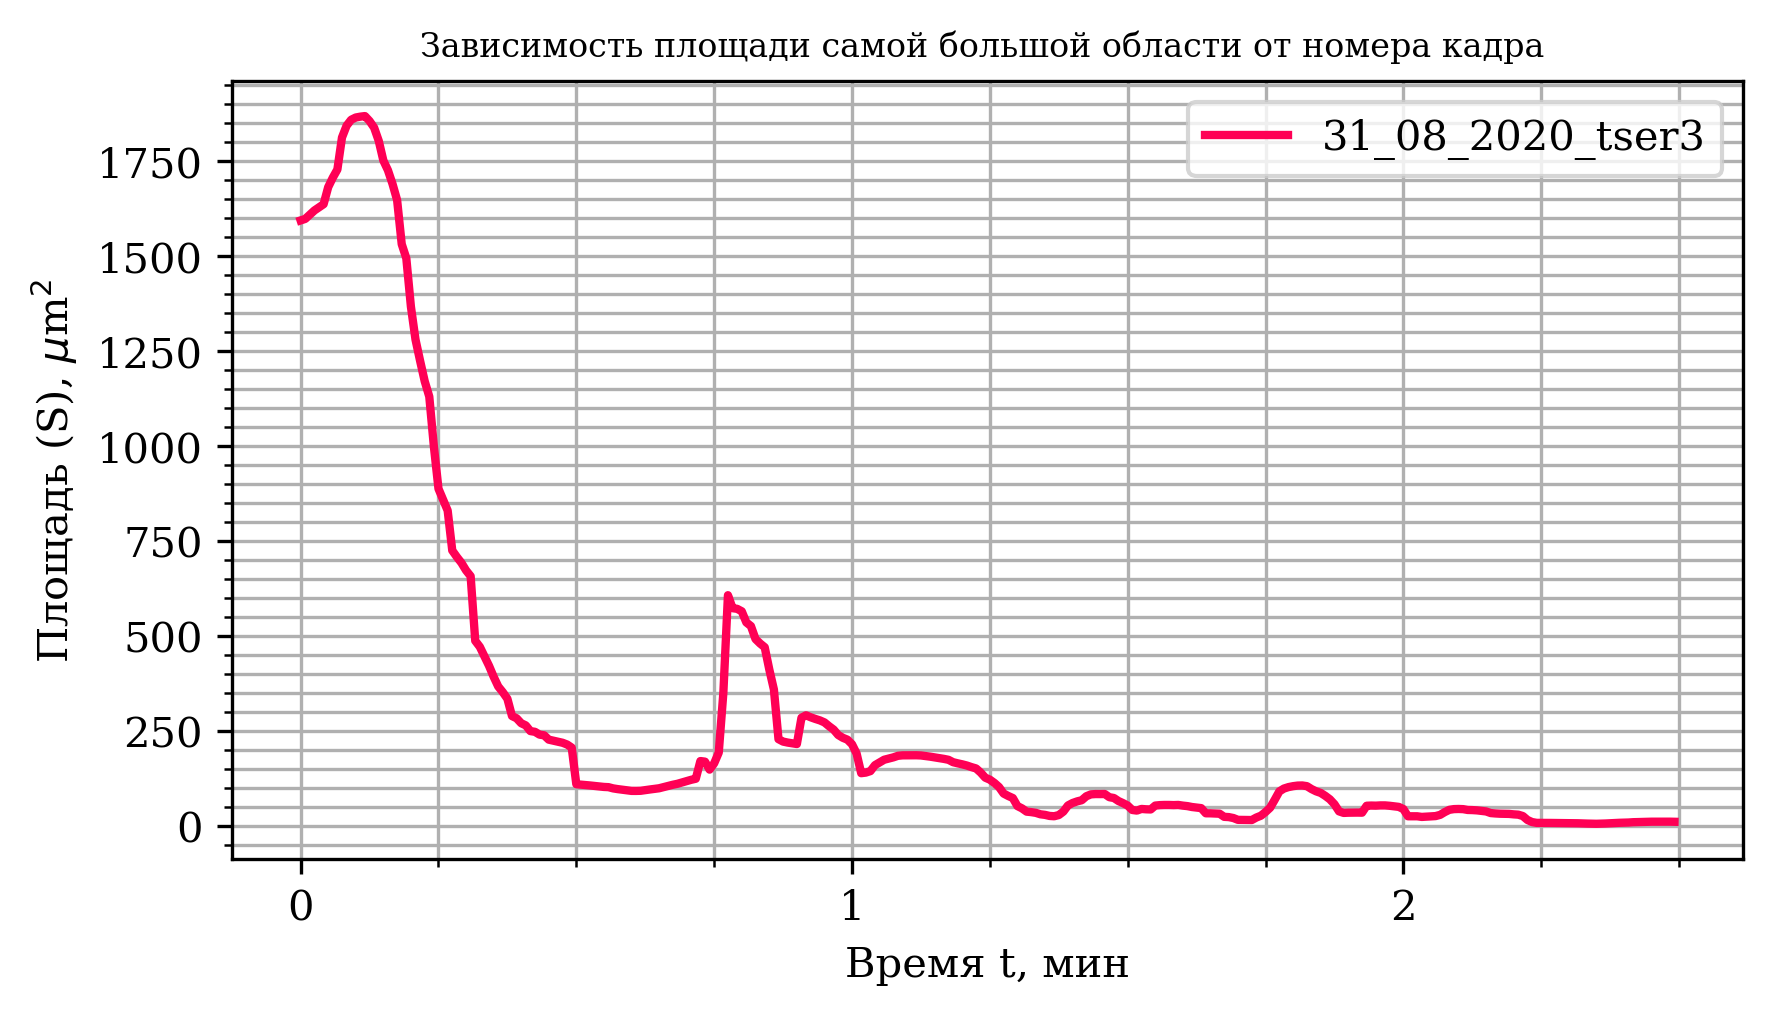

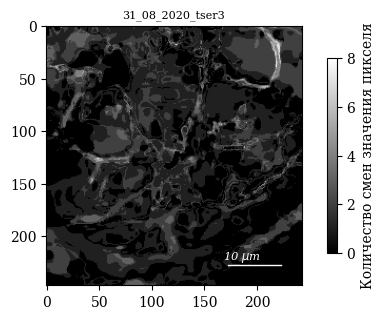

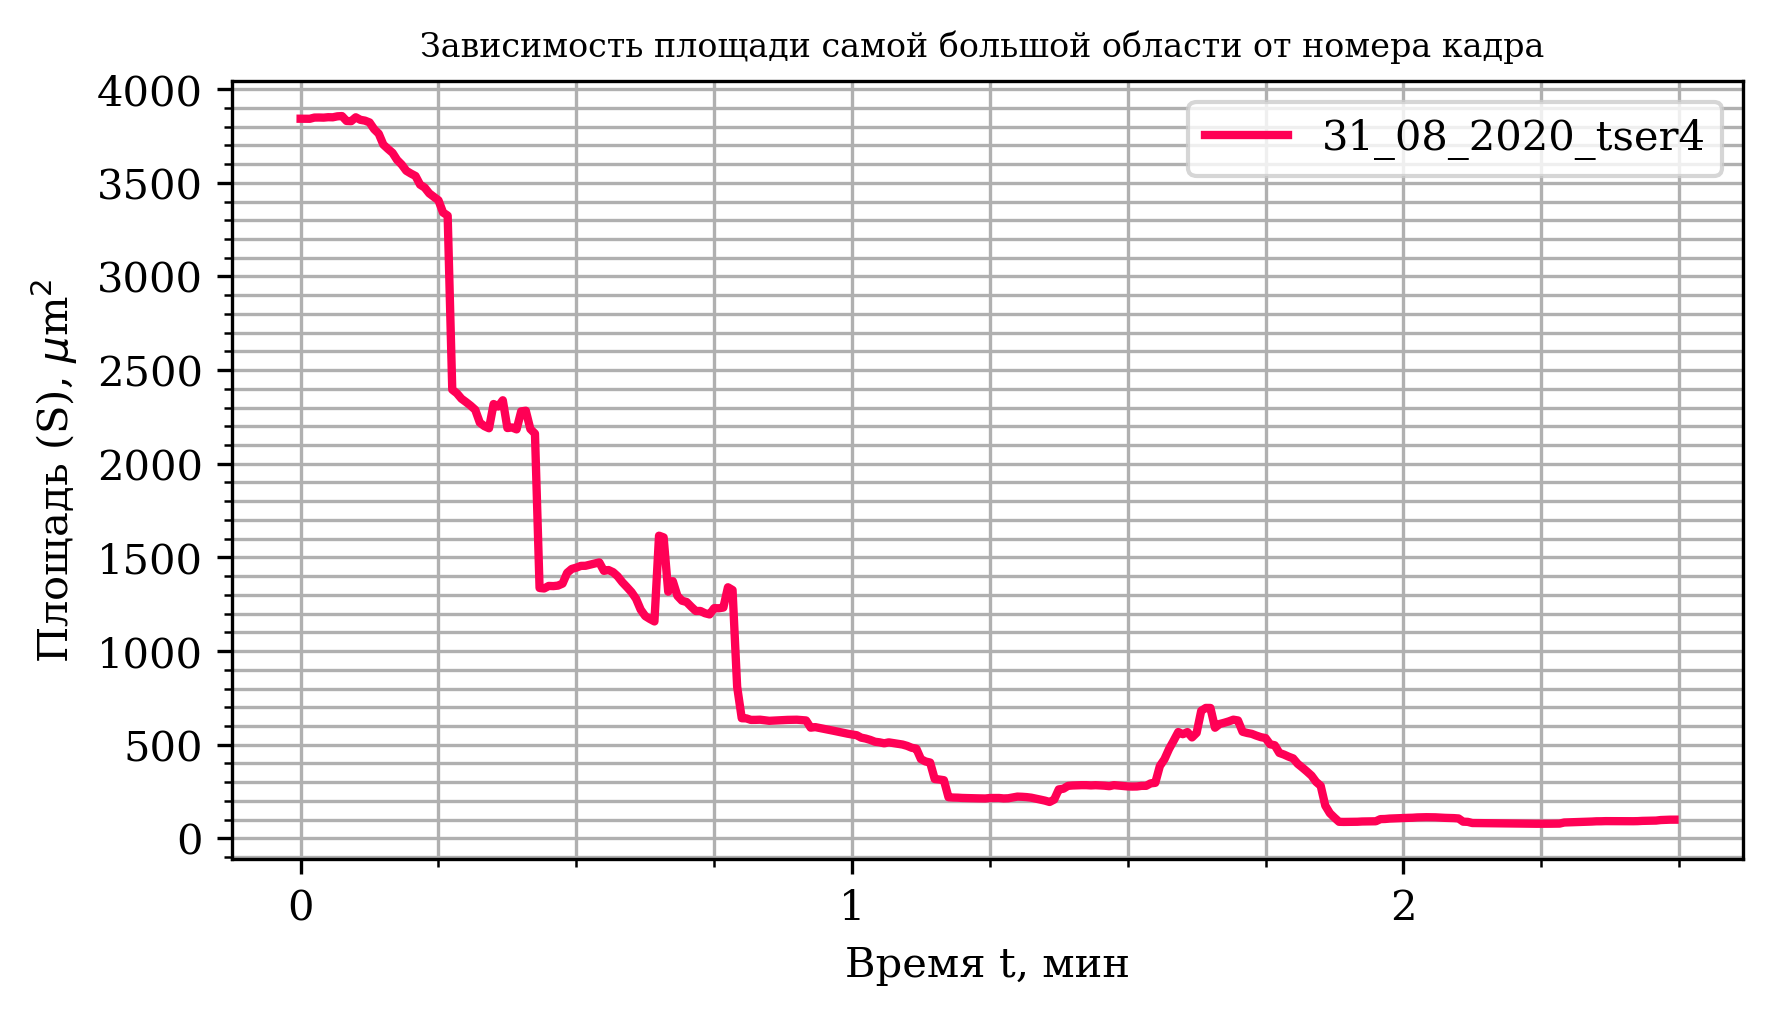

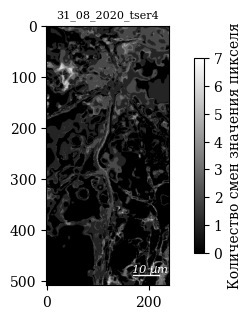

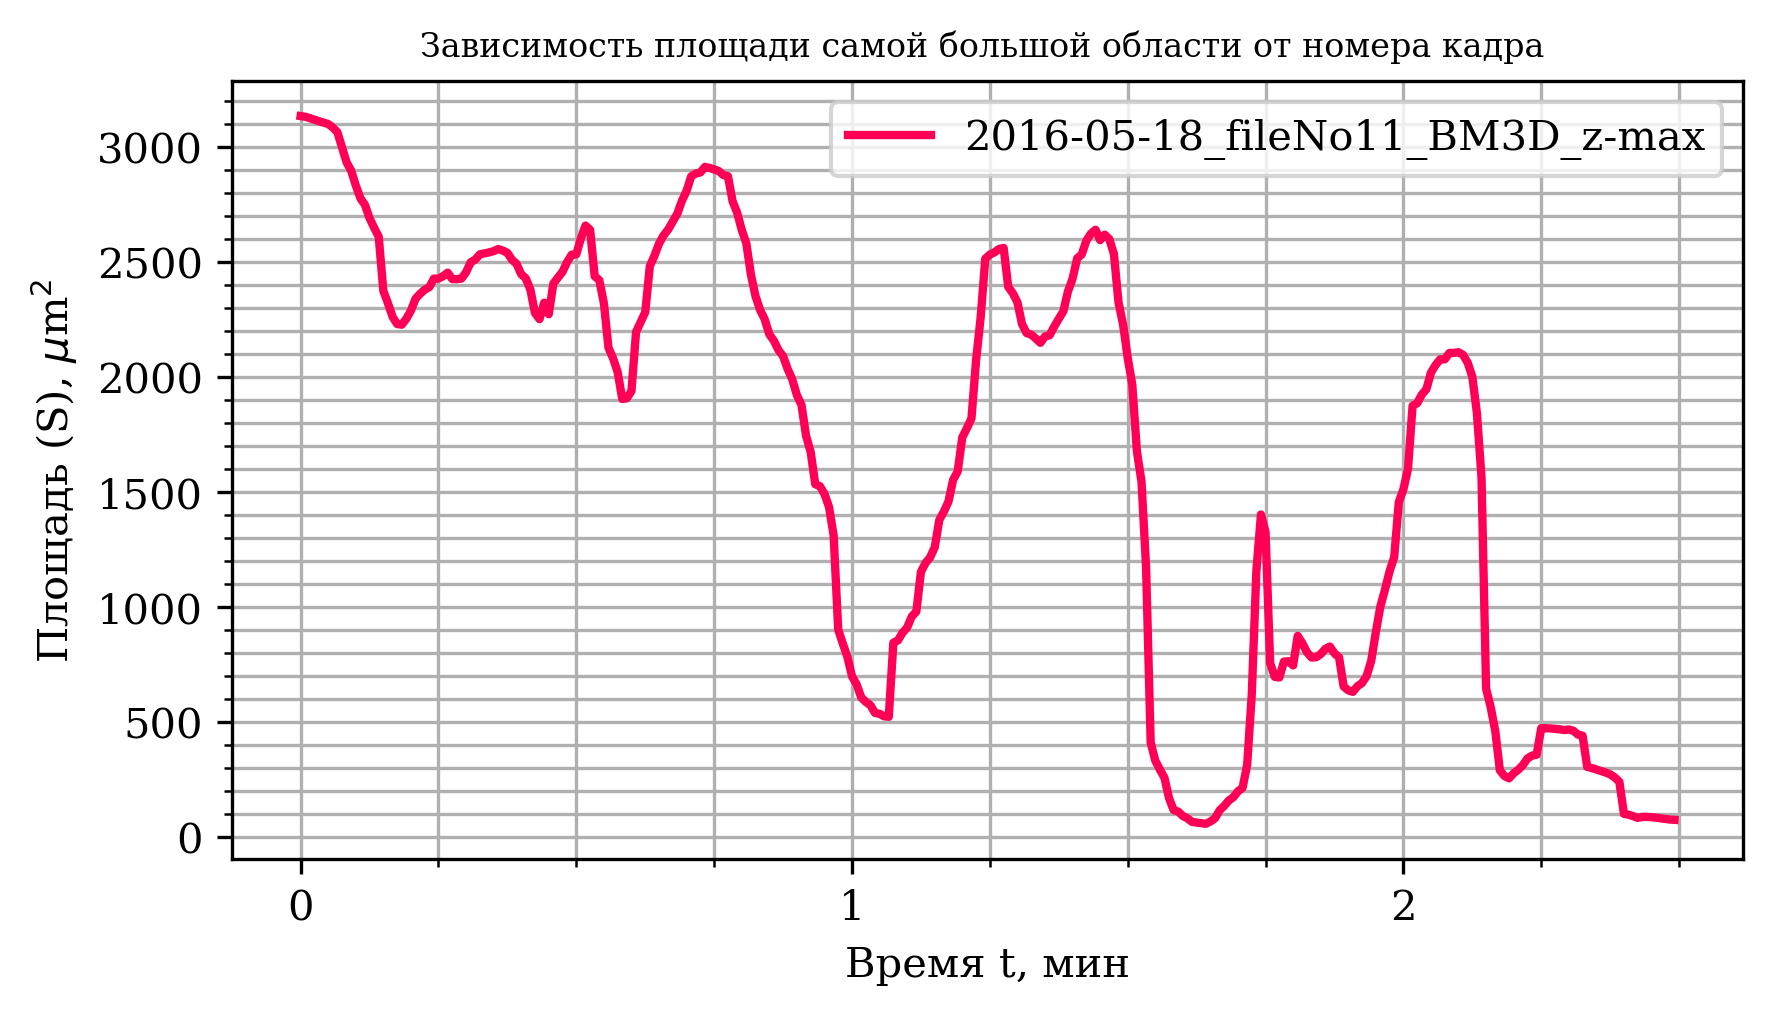

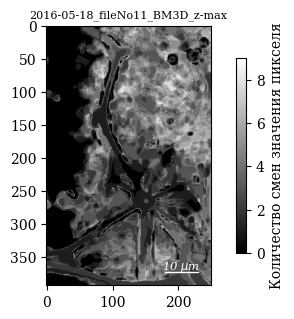

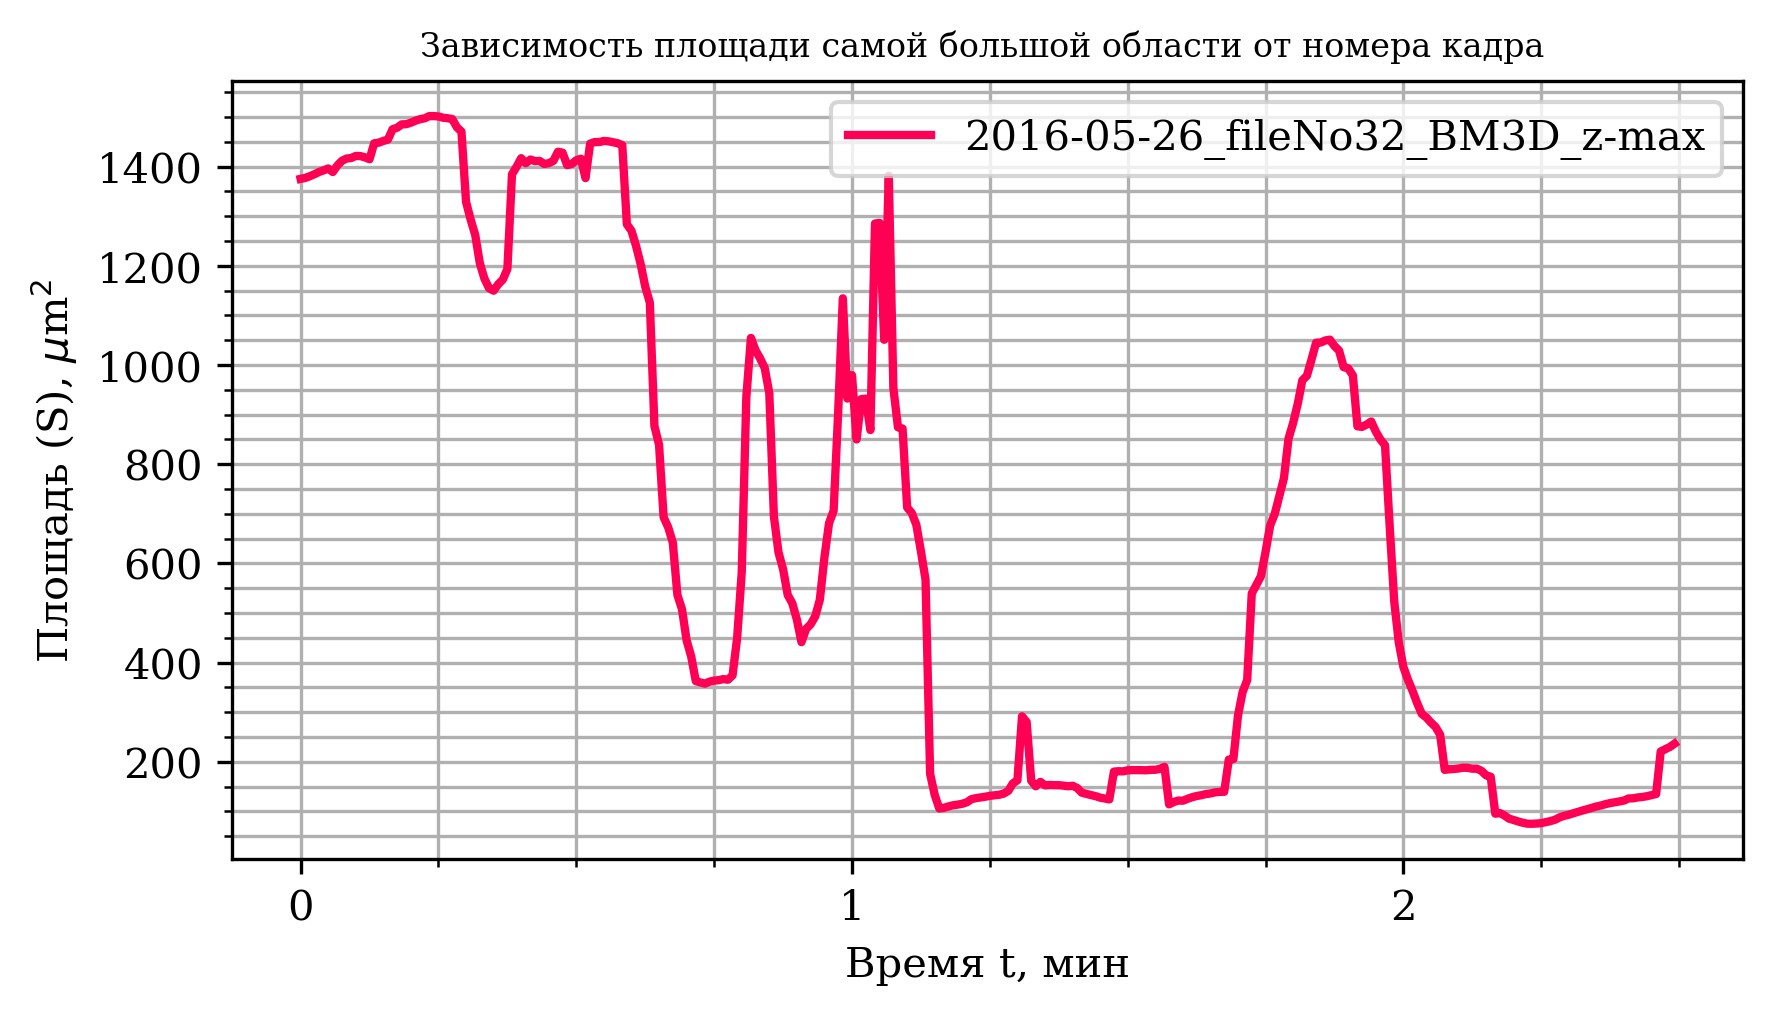

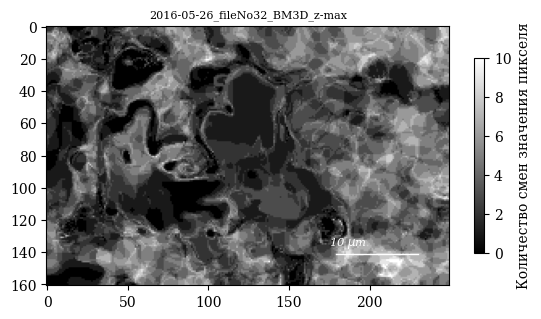

In [9]:
file_for_func_to_func8.function_to_func8(df_ev=df_all[df_all.file_path.str.contains('event')], data_dir= r'C:/Users/sibir/Desktop/results')

[https://cloud.unn.ru/s/MTj9wmBtiycGEKo/download/астроцитыотчет.docx]

[https://vk.com/away.php?to=https%3A%2F%2Fgithub.com%2FMishchenko754%2Fcongenial-spork.git&cc_key=]